In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler


from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, KFold # or StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import pingouin as pg 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score

### how to ewaluate global WM is associated with 1st PC? 

In [3]:
# read in the metric files saved as csv
controls = pd.read_csv('../../DerivedData/extracted_diffusion_metrics_control_group_mergedLR.csv', index_col=0)
preterms = pd.read_csv('../../DerivedData/extracted_diffusion_metrics_preterm_group_mergedLR.csv', index_col=0)

### create pairing - as there is fewer preterms, use their IDs to find matches with controls 
matched = pd.read_csv('../../DerivedData/subject_matching.csv', index_col=0)
matched = matched[matched['preterm_ID'].isin(preterms['subject_id'].values)]

#get matched controls
controls = controls[controls.subject_id.isin(matched.matched_ID_with_outcome.values)]

preterm_ids = preterms.subject_id.values
control_ids = controls.subject_id.values

### concatenate the two 
df = pd.concat([preterms, controls])

### get scores 
clinic = pd.read_csv('../../DerivedData/Global.csv', sep=';')
to_keep = ['ParticipantID', 'Cognitive-CompositeScore', 'Communication-CompositeScore', 'Motor-CompositeScore','Cognitive-ScaledScore',
 'ReceptiveCom-ScaledScore',
 'ExpressiveCom-ScaledScore',
 'FineMotor-ScaledScore',
 'GrossMotor-ScaledScore', 'IMDScore', 
          'Sex', 'Gabirth', 'Pregnancy-size', 'Oxygen-totaldays', 
          'ParenteralNutrition>21d', 'ChronicLungDisease']
clinic= clinic[to_keep]

clinic.rename( columns ={
                'ParticipantID' : 'subject_id',
                'Cognitive-CompositeScore' : 'Cognitive',
                'Communication-CompositeScore' : 'Language', 
                'Motor-CompositeScore' : 'Motor',
                'Gabirth': 'birth_age', 
                'Pregnancy-size' : 'MultiPreg',
                'Oxygen-totaldays': 'Oxygen_days',
                'ParenteralNutrition>21d': 'ParenteralNutrition_21d'
                }, inplace=True)

for col in ['IMDScore', 'birth_age']:
        clinic[col] = clinic[col].astype(str)
        clinic[col] = clinic[col].apply(lambda x: x.replace(',','.'))
        clinic[col] = clinic[col].astype(np.float16)
        
clinic.loc[clinic['Sex'] == 'Female', 'Sex_cat'] = 1
clinic.loc[clinic['Sex'] == 'Male', 'Sex_cat'] = 0

clinic.loc[clinic['ParenteralNutrition_21d'] == 'Yes', 'ParenteralNutrition_21d_cat'] = 1
clinic.loc[clinic['ParenteralNutrition_21d'] == 'No', 'ParenteralNutrition_21d_cat'] = 0
      
clinic.loc[clinic['ChronicLungDisease'] == 'Yes', 'ChronicLungDisease_cat'] = 1
clinic.loc[clinic['ChronicLungDisease'] == 'No', 'ChronicLungDisease_cat'] = 0

clinic['MultiPreg'] = clinic['MultiPreg'] -1
   
print('socioeconomic status missing in {} ({}%) cases'.format(len(clinic[clinic['IMDScore'].isna()]), len(clinic[clinic['IMDScore'].isna()])*100/len(clinic)))

df = pd.merge(df, clinic, how="outer", on=["subject_id"])


## inpute median ### this should be done within the validation loop!
#df['IMDScore'].fillna(df['IMDScore'].median(), inplace=True)# read in the metric files saved as csv



socioeconomic status missing in 22 (18.64406779661017%) cases


### 1. Select subjects for the PCA

In [541]:
### get IDs where the scores are missing in preterms and their control mathces 
## this will not be so easy as Sara removed some control subjects with weird age so matching will not be great OR we remove lot of things
# for now only when score missing 
import random

num_control = len(df[df['Cognitive'].isna()& df['subject_id'].isin(control_ids)])
num_preterm = len(df[df['Cognitive'].isna() & df['subject_id'].isin(preterm_ids)])

required_random_controls = num_preterm - num_control
print(required_random_controls)

miss_ids = list(df[df['Cognitive'].isna()].subject_id.values)
      
other_controls = [ subj for subj in control_ids if subj not in miss_ids]
np.random.seed(42)
random_controls = random.choices(population=control_ids, k=required_random_controls)
miss_ids.extend( random_controls)

9


### 2. Run PCA per subset && select number of PCs to keep 

['_AD', '_RD']
Kernel 95% variance: [8]
Linear 95% variance: [6]


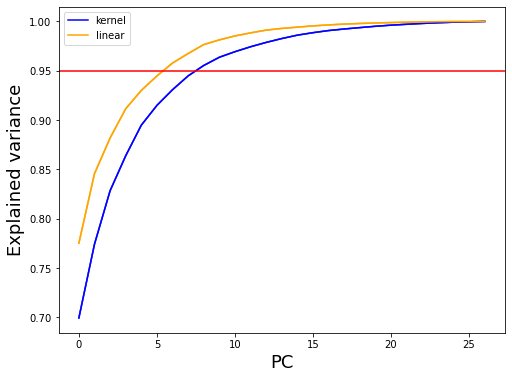

['_MD', '_FA']
Kernel 95% variance: [9]
Linear 95% variance: [6]


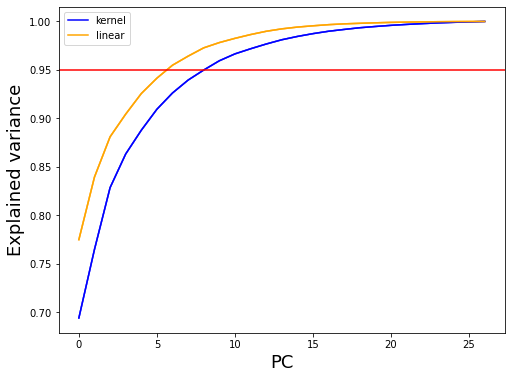

['_NDI', '_ODI']
Kernel 95% variance: [12]
Linear 95% variance: [9]


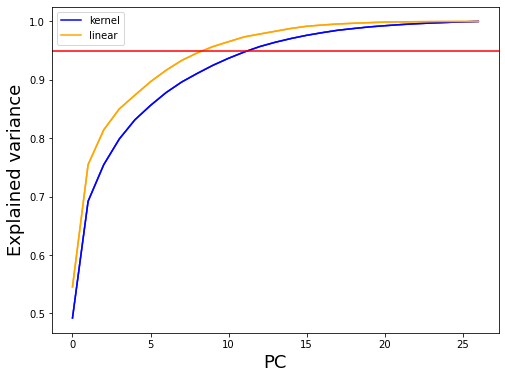

In [542]:
#DTI = ['_AD', '_RD', '_MD', '_FA', '_NDI', '_ODI']

feature_pairs = [['_AD', '_RD'], ['_MD', '_FA'], ['_NDI', '_ODI']]
feature_sets = []
top_first = []
scalers = {}

for i, metric_pair in enumerate(feature_pairs):

    features = [col for col in df.columns for metric in metric_pair if metric in col ]
    feature_sets.append(features)
    for_PCA = df[df.subject_id.isin(miss_ids)][features].values

    ## scale everything 
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(for_PCA)
    scaled_for_PCA = scaler.transform(for_PCA)
    
    ### PCA 
    pcs= min(len(scaled_for_PCA), len(scaled_for_PCA[0])) -1 
 
    lin_variances = []
    krl_variances = []


    for iteration in range(5):    
    
        pca = PCA(n_components=pcs).fit(scaled_for_PCA)
        pca_kernel = KernelPCA(n_components=pcs, kernel='rbf').fit(scaled_for_PCA)
        
        scalers[i] = pca
        X_PCA = pca.transform(scaled_for_PCA)
        X_PCA_kr = pca_kernel.transform(scaled_for_PCA)
        

        explained_variance = np.var(X_PCA_kr, axis=0)
        explained_variance_ratio = explained_variance / np.sum(explained_variance)

        lin_variances.append(pca.explained_variance_ratio_)
        krl_variances.append(explained_variance_ratio)

    ## can I use these as thresholds for grid search PCA parameter?
    print(metric_pair)
    plt.figure(figsize=(8,6))
    for i in range(len(lin_variances)):

        plt.plot(range(len(explained_variance_ratio)), np.cumsum(krl_variances[i]), c = 'blue', alpha=0.25)
        #print('Kernel 95% variance:', np.argwhere( np.cumsum(explained_variance_ratio)>0.95)[0])
        plt.plot(range(len(pca.explained_variance_ratio_)), np.cumsum(lin_variances[i]),  c='orange', alpha=0.25)
        #print('Linear 95% variance:', np.argwhere( np.cumsum(pca.explained_variance_ratio_)>0.95)[0])
    #plt.legend()


    plt.plot(range(len(explained_variance_ratio)), np.cumsum(np.mean(krl_variances,axis=0)), label='kernel', c = 'blue')
    print('Kernel 95% variance:', np.argwhere( np.cumsum(np.mean(krl_variances,axis=0))>0.95)[0])
    plt.plot(range(len(pca.explained_variance_ratio_)), np.cumsum(np.mean(lin_variances,axis=0)), label='linear', c='orange')
    print('Linear 95% variance:', np.argwhere( np.cumsum(np.mean(lin_variances,axis=0))>0.95)[0])
    
    top_first.append(np.argwhere( np.cumsum(np.mean(lin_variances,axis=0))>0.95)[0][0] + 1)
    plt.legend()

    plt.axhline(y=0.95, xmin=0, xmax=60, color='red')

    plt.ylabel('Explained variance', fontsize=18)
    plt.xlabel('PC', fontsize=18)
    plt.show()

## 3. Model building 
### 3.1 First set the predictive baseline using only IMD score as predictor

Motor results:


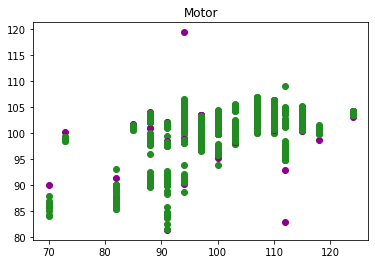

Language results:


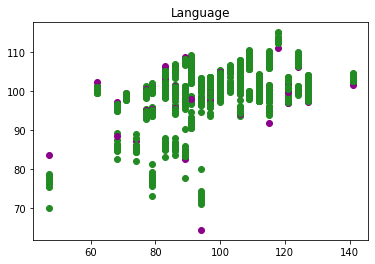

Cognitive results:


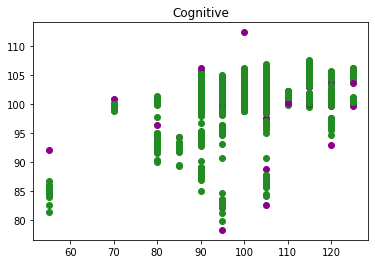

Motor results TEST:
mean R2: -0.012778589484913727
mean MAE: 7.068181818181818
corr R: 0.26271139490851825
Motor results TRAIN:
mean R2: -58.36693191865603
mean MAE: 10.556818181818182
corr R: 0.2886751345948096
Language results TEST:
mean R2: 0.08080440428401381
mean MAE: 13.181818181818182
corr R: 0.3057442617637776
Language results TRAIN:
mean R2: -67.90960692493259
mean MAE: 15.738636363636363
corr R: 0.38602579637797907
Cognitive results TEST:
mean R2: -0.037963663890991706
mean MAE: 9.193181818181818
corr R: 0.15615930471625944
Cognitive results TRAIN:
mean R2: -0.8971136653895273
mean MAE: 2.0454545454545454
corr R: 0.8756167130627651


In [539]:
## make this multiouput 

independent = ['Motor', 'Language', 'Cognitive']

X = df[~df.subject_id.isin(miss_ids)][['IMDScore', 'birth_age', 
                                       'Sex_cat', 'MultiPreg', 
                                        'Oxygen_days', 'ParenteralNutrition_21d_cat', 
                                      'ChronicLungDisease_cat']].values

#sss = KFold(n_splits=5, random_state=42, shuffle=True)
sss = LeaveOneOut()
#sss.get_n_splits(X)

results = {}

for outcome in independent:
    y = df[~df.subject_id.isin(miss_ids)][outcome].values
    
    #r = []
    #mae = []
    
    results[outcome] = {}
    results[outcome]['prediction'] = []
    results[outcome]['true'] = []
    results[outcome]['prediction_train'] = []
    results[outcome]['true_train'] = []
    
    
    for train_index, test_index in sss.split(X):
    
        X_train, X_test = X[train_index], X[test_index] 
        y_train, y_test = y[train_index], y[test_index]
        
        ### input median 
        
        for col in range(len(X_train[0])):
            md = np.nanmedian(X_train[:,col])
            X_train[:,col][np.where(np.isnan(X_train[:,col]))] = md
            X_test[:,col][np.where(np.isnan(X_test[:,col]))] = md
        
        # scale
        scaler = StandardScaler()
        scaler.fit(X_train)
        
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        ### prediction 
        #reg = LinearRegression()
        reg = Ridge(alpha=10)
        #reg = GradientBoostingRegressor(loss='huber', n_estimators=100)
        reg.fit(X_train , y_train)
        #reg.fit(X_train.reshape(-1, 1) , y_train)
    
        #y_pred = reg.predict(X_test.reshape(-1, 1) )
        y_pred = reg.predict(X_test )
        y_pred_train = reg.predict(X_train )
    
        #r.append(r2_score(y_true = y_test, y_pred=y_pred))
        #mae.append(mean_absolute_error(y_test, y_pred))
        
        plt.scatter(y_test,y_pred, c='darkmagenta')
        plt.scatter(y_train,y_pred_train, c='forestgreen')
        
        results[outcome]['prediction'].append(y_pred.astype(int)[0])
        results[outcome]['true'].append(y_test[0])
        
        results[outcome]['prediction_train'].append(y_pred_train.astype(int)[0])
        results[outcome]['true_train'].append(y_train[0])
        
        
        
    print('{} results:'.format(outcome))
    #print('mean R2: {} (std {})'.format(np.mean(r), np.std(r)))
    #print('mean MAE: {} (std {})'.format(np.mean(mae), np.std(mae)))
    
    plt.title(outcome)
    plt.show()

for outcome in independent:
    
    r2 = r2_score(y_true = results[outcome]['true'], y_pred=results[outcome]['prediction'])
    mae = mean_absolute_error(y_true = results[outcome]['true'], y_pred=results[outcome]['prediction'])
    corr = np.corrcoef(results[outcome]['true'], results[outcome]['prediction'])[0,1]
    print('{} results TEST:'.format(outcome))
    print('mean R2: {}'.format(r2))
    print('mean MAE: {}'.format(mae))
    print('corr R: {}'.format(corr))
    
    
    r2 = r2_score(y_true = results[outcome]['true_train'], y_pred=results[outcome]['prediction_train'])
    mae = mean_absolute_error(y_true = results[outcome]['true_train'], y_pred=results[outcome]['prediction_train'])
    corr = np.corrcoef(results[outcome]['true_train'], results[outcome]['prediction_train'])[0,1]
    print('{} results TRAIN:'.format(outcome))
    print('mean R2: {}'.format(r2))
    print('mean MAE: {}'.format(mae))
    print('corr R: {}'.format(corr))

Motor results:
mean R2: -0.07923421229620353
mean MAE: 7.238636363636363
corr R: 0.24910225381009973
Language results:
mean R2: 0.04362963080185478
mean MAE: 13.329545454545455
corr R: 0.28994909918248707
Cognitive results:
mean R2: -0.08442846328539
mean MAE: 9.375
corr R: 0.14927842398617636


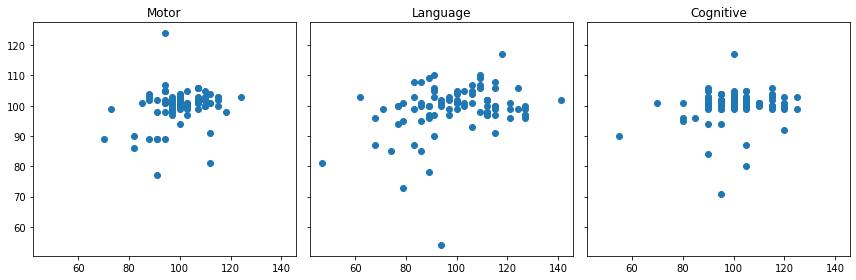

In [533]:
## try the above as multitaks 

## make this multiouput 

independent = ['Motor', 'Language', 'Cognitive']

X = df[~df.subject_id.isin(miss_ids)][['IMDScore', 'birth_age', 
                                       'Sex_cat', 'MultiPreg', 
                                        'Oxygen_days', 'ParenteralNutrition_21d_cat', 
                                      'ChronicLungDisease_cat']].values

#sss = KFold(n_splits=5, random_state=42, shuffle=True)
sss = LeaveOneOut()
#sss.get_n_splits(X)

results = {}


y = df[~df.subject_id.isin(miss_ids)][independent].values

for i, outcome in enumerate(independent):
    results[outcome] = {}
    results[outcome]['prediction'] = []
    results[outcome]['true'] = []
    
for train_index, test_index in sss.split(X):
    
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]
        
    ## input median     
    for col in range(len(X_train[0])):
        md = np.nanmedian(X_train[:,col])
        X_train[:,col][np.where(np.isnan(X_train[:,col]))] = md
        X_test[:,col][np.where(np.isnan(X_test[:,col]))] = md
        
    # scale
    scaler = StandardScaler()
    scaler.fit(X_train)
        
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)  
    
    reg = MultiTaskLasso(alpha = 0.001)
    reg.fit(X_train , y_train)
    y_pred = reg.predict(X_test )
    
    for i, outcome in enumerate(independent):
        results[outcome]['prediction'].append(y_pred.astype(int)[0][i])
        results[outcome]['true'].append(y_test[0][i])
    
fig, axs = plt.subplots(1,3, sharey=True, sharex=True, figsize=(12,4))
for i,outcome in enumerate(independent):
    
    r2 = r2_score(y_true = results[outcome]['true'], y_pred=results[outcome]['prediction'])
    mae = mean_absolute_error(y_true = results[outcome]['true'], y_pred=results[outcome]['prediction'])
    
    corr = np.corrcoef(results[outcome]['true'], results[outcome]['prediction'])[0,1]
    print('{} results:'.format(outcome))
    print('mean R2: {}'.format(r2))
    print('mean MAE: {}'.format(mae))
    print('corr R: {}'.format(corr))
    
    
    axs[i].scatter(results[outcome]['true'], results[outcome]['prediction'])
    axs[i].set_title(outcome)
plt.tight_layout()
plt.show()

### 3.2 Test predictive power of mean WM metrics (together)

In [459]:
#### get WM 
ex_WM = pd.read_csv('../../DerivedData/extreme_pairs_mean_diffusion_metrics_over_WM.csv', index_col=0)
mod_WM = pd.read_csv('../../DerivedData/moderate_pairs_mean_diffusion_metrics_over_WM.csv', index_col=0)

WM = pd.concat([ex_WM, mod_WM])
WM.rename(columns={'matched_ID' : 'control_ID'}, inplace=True)

preterm_cols = [col for col in WM.columns if 'preterm' in col]
preterm_cols = [col for col in preterm_cols if 'post' not in col]
matched_cols = [col for col in WM.columns if 'control' in col]
matched_cols = [col for col in matched_cols  if 'post' not in col]

pt = WM[preterm_cols].copy()
mt = WM[matched_cols].copy()

pt = pt.set_axis([col.split('_')[1] for col in preterm_cols] , axis=1, inplace=False)
mt = mt.set_axis([col.split('_')[1] for col in matched_cols] , axis=1, inplace=False)

pt.reset_index(drop=True, inplace=True)
mt.reset_index(drop=True, inplace=True)

#del WM

new_WM = pt.copy()
new_WM = new_WM.append(mt.copy())

new_WM = new_WM.set_axis(['meanWM_' + col for col in pt.columns] , axis=1, inplace=False)
new_WM.rename(columns={'meanWM_ID': 'subject_id'}, inplace =True)

new_WM = pd.merge( new_WM, df[['subject_id', 'Cognitive', 'Language', 'Motor', 'IMDScore']], how="inner", on=["subject_id"])
#df_DTI = pd.merge(df_DTI, new_WM, how="outer", on=["subject_id"])

Motor results:


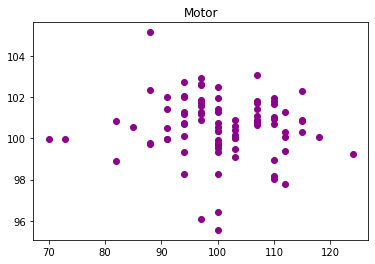

Language results:


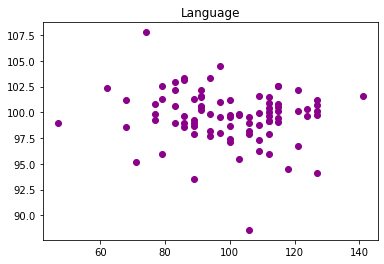

Cognitive results:


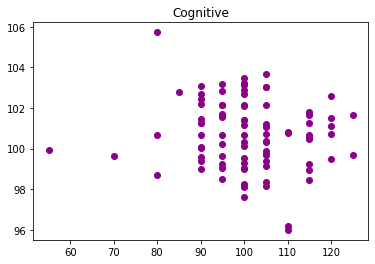

Motor results:
mean R2: -0.0330596720703169
mean MAE: 7.556818181818182
corr R: -0.0158084077158947
Language results:
mean R2: -0.05783699858805469
mean MAE: 14.704545454545455
corr R: -0.11119037904406266
Cognitive results:
mean R2: -0.05453444360333082
mean MAE: 9.136363636363637
corr R: -0.10302544929352947


In [463]:
independent = ['Motor', 'Language', 'Cognitive']

WM_cols = [col for col in new_WM.columns if 'WM' in col]

X = new_WM[~new_WM.subject_id.isin(miss_ids)][WM_cols].values
X_wm_for_PCA = new_WM[new_WM.subject_id.isin(miss_ids)][WM_cols].values

### scaler 
scaler = StandardScaler()
scaler.fit(X_wm_for_PCA)

X_wm_for_PCA = scaler.transform(X_wm_for_PCA)

### PCA 
pcs= min(len(X_wm_for_PCA), len(X_wm_for_PCA[0])) -1 
pca_WM = PCA(n_components=pcs).fit(X_wm_for_PCA)
num_WM_pcs = np.argwhere( np.cumsum(pca_WM.explained_variance_ratio_)>0.95)[0][0] + 1

### define validation 

#sss = KFold(n_splits=5, random_state=42, shuffle=True)
#sss.get_n_splits(X)
sss = LeaveOneOut()

results = {}
for outcome in independent:
    y = df[~df.subject_id.isin(miss_ids)][outcome].values
    

    #r = []
    #mae = []
    
    results[outcome] = {}
    results[outcome]['prediction'] = []
    results[outcome]['true'] = []
    
    for train_index, test_index in sss.split(X):
    
        X_train, X_test = X[train_index], X[test_index] 
        y_train, y_test = y[train_index], y[test_index]
        
        
        # scale
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        # PCA 
        X_train = pca_WM.transform(X_train)[:,:num_WM_pcs]
        X_test = pca_WM.transform(X_test)[:,:num_WM_pcs]
        

        ### prediction 
        reg = LinearRegression()
        #reg = GradientBoostingRegressor(loss='huber', n_estimators=100)
        reg.fit(X_train , y_train)
    
        y_pred = reg.predict(X_test )
    
        #r.append(r2_score(y_true = y_test, y_pred=y_pred))
        #mae.append(mean_absolute_error(y_test, y_pred))
        
        results[outcome]['prediction'].append(y_pred.astype(int)[0])
        results[outcome]['true'].append(y_test[0])
        
        plt.scatter(y_test,y_pred, c='darkmagenta')
        
    print('{} results:'.format(outcome))
    #print('mean R2: {} (std {})'.format(np.mean(r), np.std(r)))
    #print('mean MAE: {} (std {})'.format(np.mean(mae), np.std(mae)))
    
    plt.title(outcome)
    plt.show()
    
    
for outcome in independent:
    
    r2 = r2_score(y_true = results[outcome]['true'], y_pred=results[outcome]['prediction'])
    mae = mean_absolute_error(y_true = results[outcome]['true'], y_pred=results[outcome]['prediction'])
    
    corr = np.corrcoef(results[outcome]['true'], results[outcome]['prediction'])[0,1]
    print('{} results:'.format(outcome))
    print('mean R2: {}'.format(r2))
    print('mean MAE: {}'.format(mae))
    print('corr R: {}'.format(corr))

### 3.3 Combine IMD score and mean WM 

Motor results:


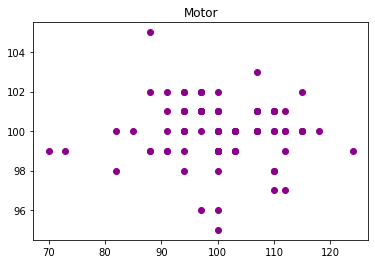

Language results:


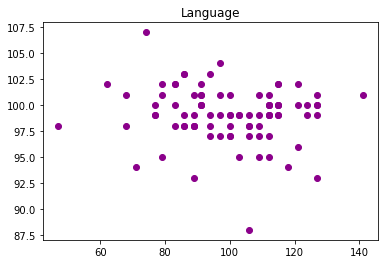

Cognitive results:


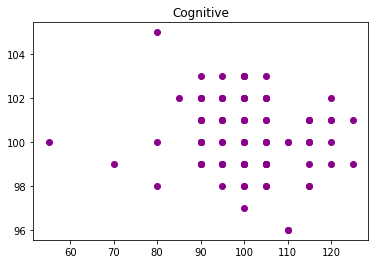

In [443]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.compose import TransformedTargetRegressor

# first do the PCA On WM 
del WM_cols

WM_cols = [col for col in new_WM.columns if 'WM' in col]
#WM_cols = ['meanWM_AD']
#WM_cols.extend(['IMDScore'])


WM_for_PCA = new_WM[new_WM.subject_id.isin(miss_ids)][WM_cols].values

## scale everything 
scaler = StandardScaler()
scaler.fit(WM_for_PCA)
scaled_WM_for_PCA = scaler.transform(WM_for_PCA)

#np.argwhere( np.cumsum(np.mean(scaled_WM_for_PCA,axis=0))>0.95)[0][0] + 1

pcs= min(len(scaled_WM_for_PCA), len(scaled_WM_for_PCA[0])) -1 
pca_WM = PCA(n_components=pcs).fit(scaled_WM_for_PCA)

num_WM_pcs = np.argwhere( np.cumsum(pca_WM.explained_variance_ratio_)>0.95)[0][0] + 1

independent = ['Motor', 'Language', 'Cognitive']

#WM_cols = [col for col in new_WM.columns if 'WM' in col]
#WM_cols = ['meanWM_AD']
WM_cols.extend(['IMDScore'])

X = new_WM[~new_WM.subject_id.isin(miss_ids)][WM_cols].values

#sss = KFold(n_splits=20, random_state=42, shuffle=True)
sss = LeaveOneOut()
#sss.get_n_splits(X)


results = {}

for outcome in independent:
    y = df[~df.subject_id.isin(miss_ids)][outcome].values
    
    #y = quantile_transform(y.reshape(-1, 1), n_quantiles=len(y), output_distribution='normal', copy=True).squeeze()
    
    r = []
    mae = []
    
    results[outcome] = {}
    results[outcome]['prediction'] = []
    results[outcome]['true'] = []
        
    
    for train_index, test_index in sss.split(X):
    
        X_train, X_test = X[train_index], X[test_index] 
        y_train, y_test = y[train_index], y[test_index]
        
        ### input median 
        
        md = np.nanmedian(X_train[:,-1])
        X_train[np.where(np.isnan(X_train))] = md
        X_test[np.where(np.isnan(X_test))] = md
        
        # scale
        #scaler = MinMaxScaler(feature_range=(0,1)).fit(X_train)
        X_train[:,:-1] = scaler.transform(X_train[:,:-1])
        X_test[:,:-1] = scaler.transform(X_test[:,:-1])
        
        # scale IMD 
        
        X_train_IMD = StandardScaler().fit_transform(X_train[:,-1].reshape(-1, 1)).reshape(1, -1)
        X_test_IMD = StandardScaler().fit_transform(X_test[:,-1].reshape(-1, 1)).reshape(1, -11)
        
        # PCA = 

        X_train_PCA = pca_WM.transform(X_train[:,:-1])[:,:num_WM_pcs]
        X_test_PCA = pca_WM.transform(X_test[:,:-1])[:,:num_WM_pcs]
        
        ## combine 
        X_train = np.zeros((X_train_PCA.shape[0], X_train_PCA.shape[1]+1))
        X_train[:,:-1] = X_train_PCA
        X_train[:,-1] =  X_train_IMD
        
        X_test = np.zeros((X_test_PCA.shape[0], X_test_PCA.shape[1]+1))
        X_test[:,:-1] = X_test_PCA
        X_test[:,-1] =  X_test_IMD
        
        
        ### prediction 
        #reg = SVR(kernel='rbf')
        reg = LinearRegression()
        #reg = TransformedTargetRegressor(regressor=LinearRegression(),
        #                         func=np.log, inverse_func=np.exp)
        #reg = GradientBoostingRegressor(loss='absolute_error', 
        #                                learning_rate = 0.01,
        #                                n_estimators=100,
        #                               max_depth = 50)
    
        reg.fit(X_train , y_train)
    
        y_pred = reg.predict(X_test )
        y_pred = y_pred.astype(int)
        
        results[outcome]['prediction'].append(y_pred.astype(int)[0])
        results[outcome]['true'].append(y_test[0])
    
        #r.append(r2_score(y_true = y_test, y_pred=y_pred))
        #mae.append(mean_absolute_error(y_test, y_pred))
        
        plt.scatter(y_test,y_pred, c='darkmagenta')
        
    print('{} results:'.format(outcome))
    #print('mean R2: {} (std {})'.format(np.mean(r), np.std(r)))
    #print('mean MAE: {} (std {})'.format(np.mean(mae), np.std(mae)))
    
    plt.title(outcome)
    plt.show()
        

In [441]:
r2_score(y_true = results['Cognitive']['true'], y_pred=results['Motor']['prediction'])


-0.03588190764572308

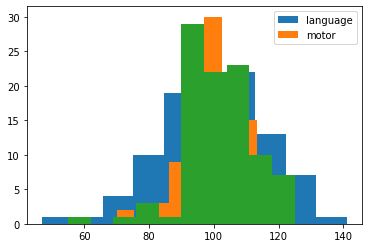

In [281]:
plt.hist(new_WM['Language'], label = 'language')
plt.hist(new_WM['Motor'], label='motor')
plt.hist(new_WM['Cognitive'])
plt.legend()
plt.show()

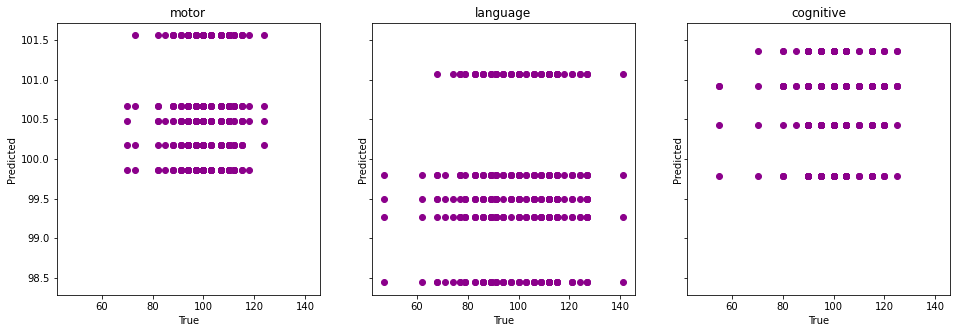

In [338]:
from sklearn.linear_model import MultiTaskLasso
independent = ['Motor', 'Language', 'Cognitive']

#WM_cols = [col for col in new_WM.columns if 'WM' in col]
WM_cols = ['meanWM_AD']
WM_cols.extend(['IMDScore'])



X = new_WM[~new_WM.subject_id.isin(miss_ids)][WM_cols].values

sss = KFold(n_splits=5, random_state=42, shuffle=True)
sss.get_n_splits(X)


y = df[~df.subject_id.isin(miss_ids)][independent].values
y.astype(int)
    
r_train = {}

r_train['motor'] = []
r_train['language'] = []
r_train['cognitive'] = []

r_test= {}

r_test['motor'] = []
r_test['language'] = []
r_test['cognitive'] = []


mae_train = {}

mae_train['motor'] = []
mae_train['language'] = []
mae_train['cognitive'] = []

mae_test = {}

mae_test['motor'] = []
mae_test['language'] = []
mae_test['cognitive'] = []

fig, axes = plt.subplots(1,3, figsize=(16,5), sharex=True, sharey=True)

for train_index, test_index in sss.split(X):
    
        X_train, X_test = X[train_index], X[test_index] 
        y_train, y_test = y[train_index], y[test_index]
        
        ### input median 
        
        md = np.nanmedian(X_train[:,-1])
        #md  = np.nanmedian(X_train)
        X_train[np.where(np.isnan(X_train))] = md
        X_test[np.where(np.isnan(X_test))] = md
        
        
        # scale
        scaler = StandardScaler().fit(X_train)
        #scaler = MinMaxScaler(feature_range=(0,1)).fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        
        reg = MultiTaskLasso(alpha=10, selection='random', max_iter=10000)
        reg.fit(X_train , y_train)
        
        y_pred_tr = reg.predict(X_train )
        y_pred_tst = reg.predict(X_test )
        
        for i, sc in enumerate(['motor', 'language', 'cognitive']):
            r_test[sc].append(r2_score(y_true = y_test[:,i], y_pred=y_pred_tst[:,i]))
            mae_test[sc].append(mean_absolute_error(y_true = y_test[:,i], y_pred=y_pred_tst[:,i]))
        
            r_train[sc].append(r2_score(y_true = y_train[:,i], y_pred=y_pred_tr[:,i]))
            mae_train[sc].append(mean_absolute_error(y_true = y_train[:,i], y_pred=y_pred_tr[:,i]))
        
        
            axes[i].scatter( y_train[:,i],y_pred_tr[:,i], color='darkmagenta')
            axes[i].set_title(sc)
            axes[i].set_xlabel('True')
            axes[i].set_ylabel('Predicted')
plt.show()
            

In [325]:
reg.score()

TypeError: score() missing 2 required positional arguments: 'X' and 'y'

In [181]:
### testing on 1 set only 

DTI = ['_AD', '_RD', '_MD', '_FA', '_NDI', '_ODI']
features = [col for col in df.columns for metric in DTI if metric in col ]

for_PCA = df[df.subject_id.isin(miss_ids)][features].values

## scale everything 
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(for_PCA)
scaled_for_PCA = scaler.transform(for_PCA)

### PCA 
pcs= min(len(scaled_for_PCA), len(scaled_for_PCA[0])) -1 
 
lin_variances = []
krl_variances = []


for iteration in range(5):    
    
    pca = PCA(n_components=pcs).fit(scaled_for_PCA)
    pca_kernel = KernelPCA(n_components=pcs, kernel='rbf').fit(scaled_for_PCA)

    X_PCA = pca.transform(scaled_for_PCA)
    X_PCA_kr = pca_kernel.transform(scaled_for_PCA)


    explained_variance = np.var(X_PCA_kr, axis=0)
    explained_variance_ratio = explained_variance / np.sum(explained_variance)

    lin_variances.append(pca.explained_variance_ratio_)
    krl_variances.append(explained_variance_ratio)
#print('PCA explained variance:{}'.format(pca.explained_variance_ratio_))
#print('kPCA explained variance:{}'.format(explained_variance_ratio))


Kernel 95% variance: [11]
Linear 95% variance: [9]


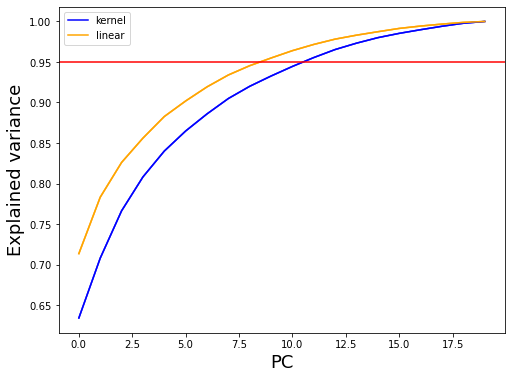

In [136]:
## can I use these as thresholds for grid search PCA parameter?

plt.figure(figsize=(8,6))
for i in range(len(lin_variances)):

    plt.plot(range(len(explained_variance_ratio)), np.cumsum(krl_variances[i]), c = 'blue', alpha=0.25)
    #print('Kernel 95% variance:', np.argwhere( np.cumsum(explained_variance_ratio)>0.95)[0])
    plt.plot(range(len(pca.explained_variance_ratio_)), np.cumsum(lin_variances[i]),  c='orange', alpha=0.25)
    #print('Linear 95% variance:', np.argwhere( np.cumsum(pca.explained_variance_ratio_)>0.95)[0])
#plt.legend()


plt.plot(range(len(explained_variance_ratio)), np.cumsum(np.mean(krl_variances,axis=0)), label='kernel', c = 'blue')
print('Kernel 95% variance:', np.argwhere( np.cumsum(np.mean(krl_variances,axis=0))>0.95)[0])
plt.plot(range(len(pca.explained_variance_ratio_)), np.cumsum(np.mean(lin_variances,axis=0)), label='linear', c='orange')
print('Linear 95% variance:', np.argwhere( np.cumsum(np.mean(lin_variances,axis=0))>0.95)[0])
plt.legend()

plt.axhline(y=0.95, xmin=0, xmax=60, color='red')

plt.ylabel('Explained variance', fontsize=18)
plt.xlabel('PC', fontsize=18)
plt.show()

In [137]:
#### get WM 
ex_WM = pd.read_csv('../../DerivedData/extreme_pairs_mean_diffusion_metrics_over_WM.csv', index_col=0)
mod_WM = pd.read_csv('../../DerivedData/moderate_pairs_mean_diffusion_metrics_over_WM.csv', index_col=0)

WM = pd.concat([ex_WM, mod_WM])
WM.rename(columns={'matched_ID' : 'control_ID'}, inplace=True)

preterm_cols = [col for col in WM.columns if 'preterm' in col]
preterm_cols = [col for col in preterm_cols if 'post' not in col]
matched_cols = [col for col in WM.columns if 'control' in col]
matched_cols = [col for col in matched_cols  if 'post' not in col]

pt = WM[preterm_cols].copy()
mt = WM[matched_cols].copy()

pt = pt.set_axis([col.split('_')[1] for col in preterm_cols] , axis=1, inplace=False)
mt = mt.set_axis([col.split('_')[1] for col in matched_cols] , axis=1, inplace=False)

pt.reset_index(drop=True, inplace=True)
mt.reset_index(drop=True, inplace=True)

#del WM

new_WM = pt.copy()
new_WM = new_WM.append(mt.copy())

new_WM = new_WM.set_axis(['meanWM_' + col for col in pt.columns] , axis=1, inplace=False)
new_WM.rename(columns={'meanWM_ID': 'subject_id'}, inplace =True)

#df = pd.merge(df, new_WM, how="outer", on=["subject_id"])
#df_DTI = pd.merge(df_DTI, new_WM, how="outer", on=["subject_id"])

In [138]:
new_WM_PCA = new_WM[new_WM['subject_id'].isin(miss_ids)]
WM_cols = ['meanWM_AD', 'meanWM_RD', 'meanWM_MD', 'meanWM_FA',
           'meanWM_NDI', 'meanWM_ODI']

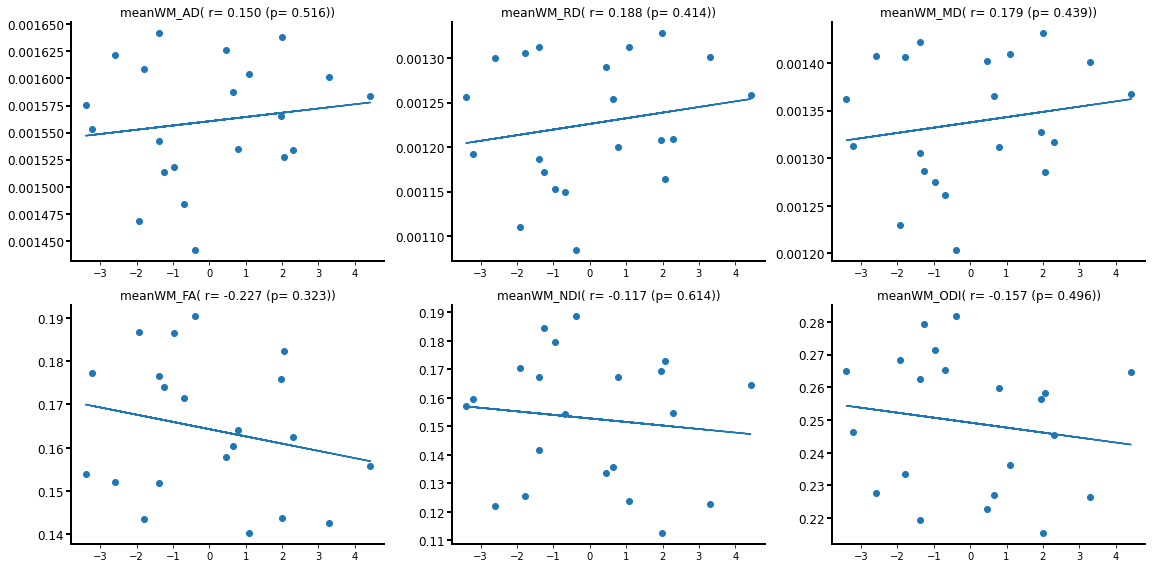

In [139]:
fig, axs = plt.subplots(2,3, figsize=(16,8))
axs = axs.ravel()

for i, col in enumerate(WM_cols):
    
    axs[i].scatter(X_PCA[:,0], new_WM_PCA[col], label=col )
    
    test = pg.corr(X_PCA[:,0], new_WM_PCA[col],)
    p_val = np.float32(test['p-val'][0])
    axs[i].set_title(col + '( r= {:.3f} (p= {:.3f}))'.format(
                                np.float32(test['r'][0]), np.round(p_val,3)), fontsize=12)
    
    m, b = np.polyfit(X_PCA[:,0], new_WM_PCA[col], 1)
    axs[i].plot(X_PCA[:,0], 
                                  m* X_PCA[:,0] + b)

    
fig.patch.set_facecolor('white')

#axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), 
#           ncol = 4, fontsize=18, frameon=False, markerscale=0.6)   

for i in range(6):
    for j in range(3):
        # Hide the right and top spines
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)
        for axis in ['bottom','left']:
            axs[i].spines[axis].set_linewidth(2)
        
        axs[i].tick_params(axis='y', labelsize=12)    
        plt.setp(axs[i].yaxis.get_ticklines(), 'markeredgewidth', 2)
        plt.setp(axs[i].yaxis.get_ticklines(), 'markersize', 5)

        
plt.tight_layout()
plt.show()
#plt.legend()
#plt.show()

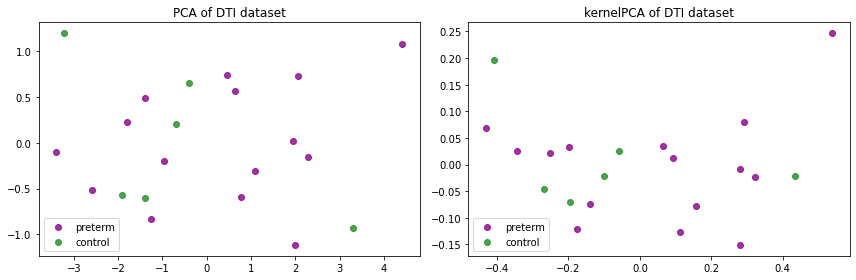

In [140]:
### plot the first two components 
colors = ["darkmagenta", "forestgreen"]
target_names = ['preterm', "control"]

groups = np.zeros_like(miss_ids)
for i, label in enumerate(miss_ids):
    if label in control_ids:
        groups[i] = 1
        
#print(
#    "explained variance ratio (first two components): %s"
#    % str(pca.explained_variance_ratio_)
#)

fig, axs = plt.subplots(1,2, figsize=(12,4))
for color, i, target_name in zip(colors, [0,1], target_names):
    
    axs[0].scatter(X_PCA[groups==i,0], X_PCA[groups==i,1], color=color, alpha = 0.8, label=target_name)

axs[0].legend(loc="best", shadow=False, scatterpoints=1)
axs[0].set_title("PCA of DTI dataset")



for color, i, target_name in zip(colors, [0,1], target_names):
    
    axs[1].scatter(X_PCA_kr[groups==i,0], X_PCA_kr[groups==i,1], color=color, alpha = 0.8, label=target_name)

axs[1].legend(loc="best", shadow=False, scatterpoints=1)
axs[1].set_title("kernelPCA of DTI dataset")
plt.tight_layout()
plt.show()

### Let's pretend this is a good PCA == first 6 components explain >95% variance 

Try to predict stuff:

**N.B** will be adding NODDI metrics & IMD scores soon 


### First test 

1. split train/test
2. Use the scaler learnt during PCA 
3. Use the trained PCA - get first 6 features that explain 95% variance
4. train linear regression model
5. evaluate 

In [141]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit # or StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import pingouin as pg 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score

In [106]:
#features_with_IMD =  np.append(features, ['IMDScore'])

In [142]:
independent = 'Motor'
num_pcs = 9
X = df[~df.subject_id.isin(miss_ids)][features].values
y = df[~df.subject_id.isin(miss_ids)][independent].values

sss = ShuffleSplit(n_splits=10, test_size=0.25)
sss.get_n_splits(X)

#train_index, test_index = next(sss.split(X, y)) 
r = []
mae = []

for train_index, test_index in sss.split(X):
    
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]
    
    ### inpute median to IMD when using here
    # how to scale properly?
    
    
    # scale
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # PCA 
    
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    
    X_train = X_train[:,:num_pcs]
    X_test = X_test[:,:num_pcs]
    
    ### prediction 
    reg = SVR()
    #reg = GradientBoostingRegressor(loss='huber', n_estimators=100)
    reg.fit(X_train, y_train)
    
    y_pred = reg.predict(X_test)
    
    r.append(r2_score(y_true = y_test, y_pred=y_pred))
    mae.append(mean_absolute_error(y_test, y_pred))


In [143]:
print('MAE: {} (std {})'.format(np.mean(mae), np.std(mae)))
print('R2: {} (std {})'.format(np.mean(r), np.std(r)))

MAE: 7.119068489072612 (std 0.770089895178082)
R2: -0.04868618951413699 (std 0.0740953329103724)


In [145]:
from pingouin import corr

corr(y_test, y_pred)

,n,r,CI95%,p-val,BF10,power
pearson,25,-0.086199,"[-0.47, 0.32]",0.682029,0.269,0.069079
